In [2]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# ANOVA feature selection
from sklearn.feature_selection import SelectKBest, f_classif

import re

# Set random seed for reproducibility
np.random.seed(42)


In [7]:
# Show full column width, all columns and all rows
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [25]:
# Load dataset
df_raw = pd.read_csv("./data.csv")

print(df_raw.head())

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                                  0.370594   
1          1                                                  0.464291   
2          1                                                  0.426071   
3          1                                                  0.399844   
4          1                                                  0.465022   

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                            0.405750   
1                                            0.516730   
2                                            0.472295   
3                                            0.457

In [28]:
def custom_clean_column_names(df):
    """
    Cleans DataFrame column names using custom rules:
    - Remove leading/trailing spaces
    - Replace '%' with 'pct'
    - Replace '/' with ' over '
    - Replace '-' with '_'
    - Remove '?' symbol
    - Replace 'Yuan ¥' with 'Yuan'
    - Replace '(' with '_'
    - Remove ')'
    - Replace spaces with '_'
    - Collapse multiple underscores
    """
    
    df_cleaned = df.copy()     # Create a copy to avoid modifying original   
    cleaned = []
    for col in df.columns:
        col = col.strip()                      # Remove leading/trailing spaces
        col = col.replace('%', 'pct')          # Replace % with pct
        col = col.replace('/', ' over ')       # Replace / with over
        col = col.replace('-', '_')            # Replace - with _
        col = col.replace('?', '')             # Remove ?
        col = col.replace('Yuan ¥', 'Yuan')    # Remove ¥
        col = col.replace("'", '')             # Remove '
        col = col.replace('(', '_')            # Replace ( with _
        col = col.replace(')', '')             # Remove )
        col = re.sub(r'\s+', '_', col)         # Replace spaces with _
        col = re.sub(r'_+', '_', col)          # Collapse multiple underscores
        cleaned.append(col)
    df_cleaned.columns = cleaned
    return df_cleaned

df_bank = custom_clean_column_names(df_raw)

In [29]:
print("Dataset Shape:", df_bank.shape)
display(df_bank.head())

Dataset Shape: (6819, 96)


,Bankrupt,ROA_C_before_interest_and_depreciation_before_interest,ROA_A_before_interest_and_pct_after_tax,ROA_B_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre_tax_net_Interest_Rate,After_tax_net_Interest_Rate,Non_industry_income_and_expenditure_over_revenue,Continuous_interest_rate_after_tax,Operating_Expense_Rate,Research_and_development_expense_rate,Cash_flow_rate,Interest_bearing_debt_interest_rate,Tax_rate_A,Net_Value_Per_Share_B,Net_Value_Per_Share_A,Net_Value_Per_Share_C,Persistent_EPS_in_the_Last_Four_Seasons,Cash_Flow_Per_Share,Revenue_Per_Share_Yuan,Operating_Profit_Per_Share_Yuan,Per_Share_Net_profit_before_tax_Yuan,Realized_Sales_Gross_Profit_Growth_Rate,Operating_Profit_Growth_Rate,After_tax_Net_Profit_Growth_Rate,Regular_Net_Profit_Growth_Rate,Continuous_Net_Profit_Growth_Rate,Total_Asset_Growth_Rate,Net_Value_Growth_Rate,Total_Asset_Return_Growth_Rate_Ratio,Cash_Reinvestment_pct,Current_Ratio,Quick_Ratio,Interest_Expense_Ratio,Total_debt_over_Total_net_worth,Debt_ratio_pct,Net_worth_over_Assets,Long_term_fund_suitability_ratio_A,Borrowing_dependency,Contingent_liabilities_over_Net_worth,Operating_profit_over_Paid_in_capital,Net_profit_before_tax_over_Paid_in_capital,Inventory_and_accounts_receivable_over_Net_value,Total_Asset_Turnover,Accounts_Receivable_Turnover,Average_Collection_Days,Inventory_Turnover_Rate_times,Fixed_Assets_Turnover_Frequency,Net_Worth_Turnover_Rate_times,Revenue_per_person,Operating_profit_per_person,Allocation_rate_per_person,Working_Capital_to_Total_Assets,Quick_Assets_over_Total_Assets,Current_Assets_over_Total_Assets,Cash_over_Total_Assets,Quick_Assets_over_Current_Liability,Cash_over_Current_Liability,Current_Liability_to_Assets,Operating_Funds_to_Liability,Inventory_over_Working_Capital,Inventory_over_Current_Liability,Current_Liabilities_over_Liability,Working_Capital_over_Equity,Current_Liabilities_over_Equity,Long_term_Liability_to_Current_Assets,Retained_Earnings_to_Total_Assets,Total_income_over_Total_expense,Total_expense_over_Assets,Current_Asset_Turnover_Rate,Quick_Asset_Turnover_Rate,Working_capitcal_Turnover_Rate,Cash_Turnover_Rate,Cash_Flow_to_Sales,Fixed_Assets_to_Assets,Current_Liability_to_Liability,Current_Liability_to_Equity,Equity_to_Long_term_Liability,Cash_Flow_to_Total_Assets,Cash_Flow_to_Liability,CFO_to_Assets,Cash_Flow_to_Equity,Current_Liability_to_Current_Assets,Liability_Assets_Flag,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No_credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholders_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_DFL,Interest_Coverage_Ratio_Interest_expense_to_EBIT,Net_Income_Flag,Equity_to_Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.06

In [30]:
# Data info
print("\nData Information:")
print(df_bank.info())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Bankrupt                                                6819 non-null   int64  
 1   ROA_C_before_interest_and_depreciation_before_interest  6819 non-null   float64
 2   ROA_A_before_interest_and_pct_after_tax                 6819 non-null   float64
 3   ROA_B_before_interest_and_depreciation_after_tax        6819 non-null   float64
 4   Operating_Gross_Margin                                  6819 non-null   float64
 5   Realized_Sales_Gross_Margin                             6819 non-null   float64
 6   Operating_Profit_Rate                                   6819 non-null   float64
 7   Pre_tax_net_Interest_Rate                               6819 non-null   float64
 8   After_tax_net_Inter

In [31]:
# Check null values
print("\nMissing Values:", df_bank.isnull().sum().sum())


Missing Values: 0


C:\Users\STAK\AppData\Local\Temp\ipykernel_26828\2710832261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Bankrupt', data=df_bank, palette='coolwarm')


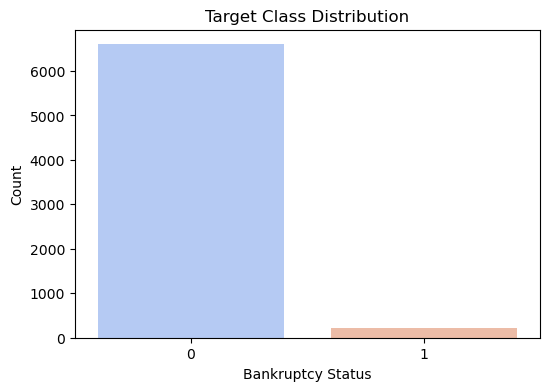

Class distribution:
Bankrupt
0    0.967737
1    0.032263
Name: proportion, dtype: float64


In [32]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Bankrupt', data=df_bank, palette='coolwarm')
plt.title("Target Class Distribution")
plt.xlabel("Bankruptcy Status")
plt.ylabel("Count")
plt.show()

print("Class distribution:")
print(df_bank['Bankrupt'].value_counts(normalize=True))


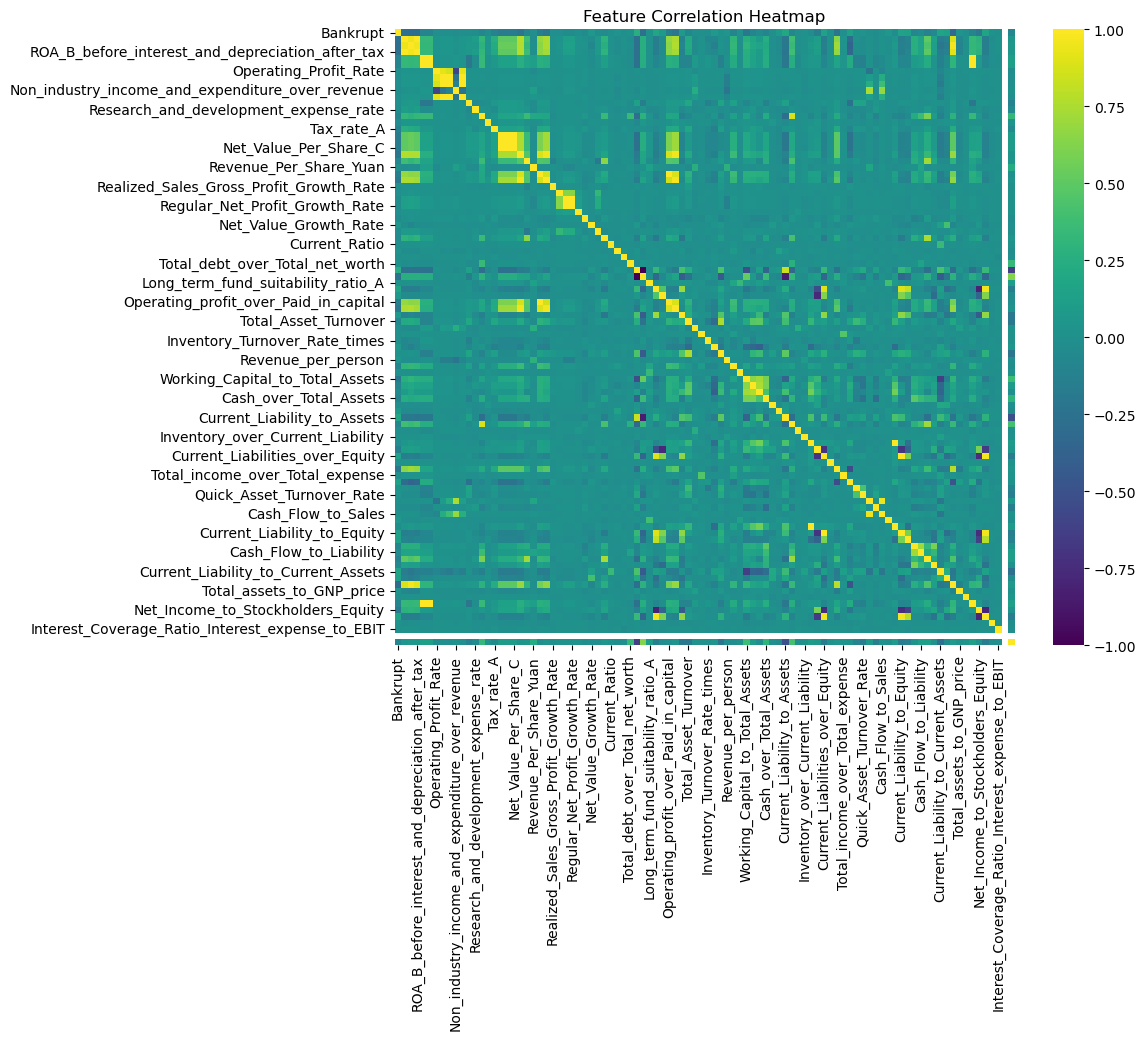

In [33]:
# Visualize correlation
plt.figure(figsize=(10,8))
sns.heatmap(df_bank.corr(), cmap='viridis', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [34]:
# Separate features and target
X = df_bank.drop(columns=['Bankrupt'])
y = df_bank['Bankrupt']

In [35]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# ANOVA feature selection - picking top 30 features
selector = SelectKBest(score_func=f_classif, k=30)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

Selected Features: ['ROA_C_before_interest_and_depreciation_before_interest', 'ROA_A_before_interest_and_pct_after_tax', 'ROA_B_before_interest_and_depreciation_after_tax', 'Tax_rate_A', 'Net_Value_Per_Share_B', 'Net_Value_Per_Share_A', 'Net_Value_Per_Share_C', 'Persistent_EPS_in_the_Last_Four_Seasons', 'Operating_Profit_Per_Share_Yuan', 'Per_Share_Net_profit_before_tax_Yuan', 'Debt_ratio_pct', 'Net_worth_over_Assets', 'Borrowing_dependency', 'Operating_profit_over_Paid_in_capital', 'Net_profit_before_tax_over_Paid_in_capital', 'Working_Capital_to_Total_Assets', 'Cash_over_Total_Assets', 'Current_Liability_to_Assets', 'Working_Capital_over_Equity', 'Current_Liabilities_over_Equity', 'Retained_Earnings_to_Total_Assets', 'Total_expense_over_Assets', 'Current_Liability_to_Equity', 'Equity_to_Long_term_Liability', 'CFO_to_Assets', 'Current_Liability_to_Current_Assets', 'Liability_Assets_Flag', 'Net_Income_to_Total_Assets', 'Net_Income_to_Stockholders_Equity', 'Liability_to_Equity']


c:\Users\STAK\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\STAK\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [52]:
# Handling imbalance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_selected, y)

print("Original dataset shape:", np.bincount(y))
print("Resampled dataset shape:", np.bincount(y_res))

Original dataset shape: [6599  220]
Resampled dataset shape: [6599 6599]


c:\Users\STAK\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [53]:
# Train-test-validation split (80-10-10)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       660
           1       0.88      0.87      0.88       660

    accuracy                           0.88      1320
   macro avg       0.88      0.88      0.88      1320
weighted avg       0.88      0.88      0.88      1320

ROC-AUC: 0.9502112029384756


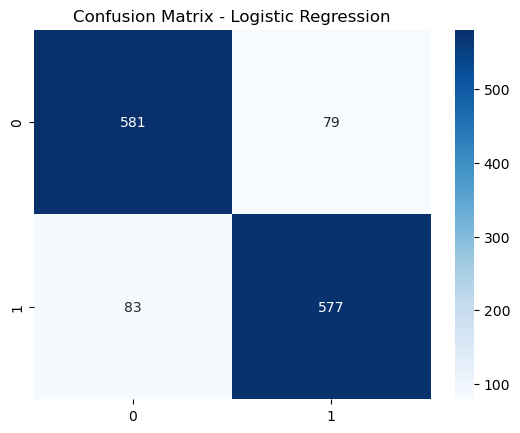

In [54]:
# Logistic Regression Model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_full, y_train_full)  # Train on full training set

y_pred_lr = log_model.predict(X_test)
y_prob_lr = log_model.predict_proba(X_test)[:,1]

print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [55]:
# Neural Network Model
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_full.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = nn_model.fit(
    X_train_full, y_train_full,
    # validation_data=(X_test, y_test),
    validation_data=(X_val, y_val),  # Use validation set here
    epochs=100, batch_size=32,
    verbose=1, callbacks=[early_stop]
)


c:\Users\STAK\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7950 - loss: 0.4749 - val_accuracy: 0.8932 - val_loss: 0.2713
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8716 - loss: 0.3022 - val_accuracy: 0.9008 - val_loss: 0.2521
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8865 - loss: 0.2828 - val_accuracy: 0.9015 - val_loss: 0.2413
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8834 - loss: 0.2798 - val_accuracy: 0.9015 - val_loss: 0.2319
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8967 - loss: 0.2513 - val_accuracy: 0.9076 - val_loss: 0.2217
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9032 - loss: 0.2396 - val_accuracy: 0.9159 - val_loss: 0.2144
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9090 - loss: 0.2306 - val_accuracy: 0.9182 - val_loss: 0.2099
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9021 - loss: 0.2332 - val_accu

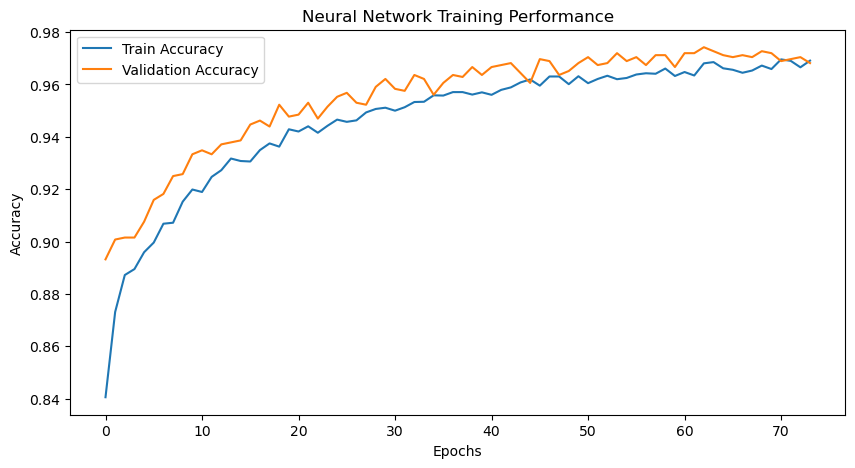

In [56]:
# Performance Evaluation for nerual network
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Neural Network Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Performance
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       660
           1       0.96      1.00      0.98       660

    accuracy                           0.98      1320
   macro avg       0.98      0.98      0.98      1320
weighted avg       0.98      0.98      0.98      1320

ROC-AUC: 0.9905325987144169


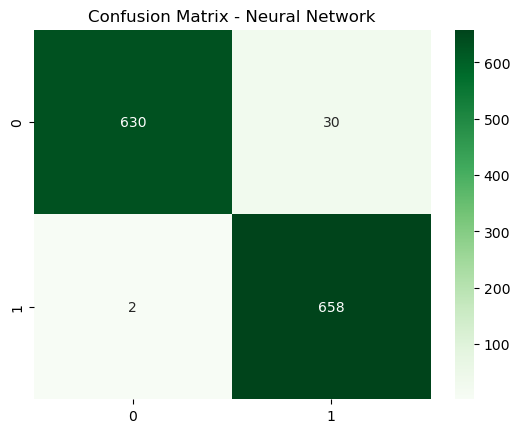

In [57]:
y_prob_nn = nn_model.predict(X_test).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

print("Neural Network Performance")
print(classification_report(y_test, y_pred_nn))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_nn))

sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Neural Network")
plt.show()


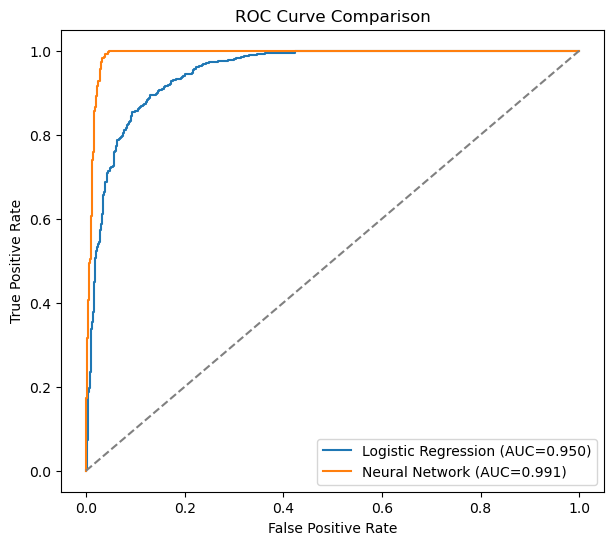

In [58]:
# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={roc_auc_score(y_test, y_prob_lr):.3f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC={roc_auc_score(y_test, y_prob_nn):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()